In [2]:
import os, gc , pickle
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse
import seaborn as sns
import numpy as np
from colorama import Fore, Back ,Style
from matplotlib.ticker import MaxNLocator

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import Ridge
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error


DATA_DIR = "./input/"
FP_CELL_METADATA = os.path.join(DATA_DIR, "metadata.csv")

FP_CITE_TRAIN_INPUTS = os.path.join(DATA_DIR , "train_cite_inputs.h5")
FP_CITE_TRAIN_TARGETS = os.path.join(DATA_DIR, "train_cite_targets.h5")
FP_CITE_TEST_INPUTS = os.path.join(DATA_DIR, "test_cite_inputs.h5")


FP_MULTIOME_TRAIN_INPUTS = os.path.join(DATA_DIR, "train_mulit_inputs.h5")
FP_MULTIOME_TRAIN_TARGETS = os.path.join(DATA_DIR, "train_multi_targets.h5")
FP_MULTIOME_TEST_INPUTS = os.path.join(DATA_DIR, "test_multi_inputs.h5")

FP_SUBMISSION = os.path.join(DATA_DIR, "sample_submission.csv")
FP_EVALUATION_IDS = os.path.join(DATA_DIR, "evaluation_ids.csv")

In [3]:
cite_train_x = pd.read_hdf(FP_CITE_TRAIN_INPUTS)

c:\users\data\appdata\local\programs\python\python38\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
c:\users\data\appdata\local\programs\python\python38\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


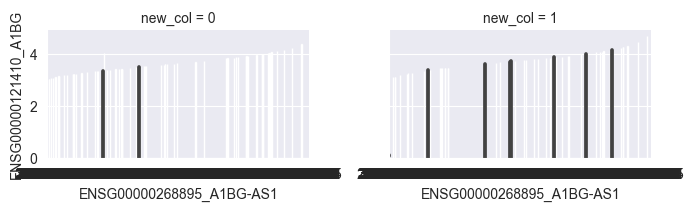

In [16]:
import seaborn as sns

grid= sns.FacetGrid(data=cite_train_x , col='new_col', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'ENSG00000268895_A1BG-AS1','ENSG00000121410_A1BG')


In [15]:
cite_train_x.columns.tolist()[0]

'ENSG00000121410_A1BG'

In [11]:
cite_train_x['new_col'] = ([0]* (70988//2)) + ([1]* (70988//2))

11025

In [11]:
import matplotlib.pyplot as plt

In [10]:
 len(([1]* (22050//2)))


11025

In [12]:

for col in cols:
    # axs[0][0].hist(cite_train_x[col].values)
     axs.ravel()

NameError: name 'cols' is not defined

In [ ]:
df_cite_train_y = pd.read_hdf(FP_CITE_TRAIN_TARGETS)
cite_protein_names = list(df_cite_train_y.columns)

In [ ]:
cite_gene_names = list(cite_train_x.columns)

In [ ]:
matching_names = []
for protein in cite_protein_names:
    matching_names += [(gene, protein) for gene in cite_gene_names if protein in gene]

pd.DataFrame(matching_names, columns=['Gene', 'Protein'])

In [ ]:

# 컬럼을 따로 떼놓지 말고 같이 순회해야하므로 zip으로 묶는다
#cols = cite_train_x.columns
fig, axs = plt.subplots(4,4,figsize=(10,10))
for col, ax in zip(encode_genes[:20],axs.ravel()):
    nonzeros = cite_train_x[col].values
    nonzeros = nonzeros[nonzeros!=0]
    ax.hist( nonzeros,bins=100,density=True)
    ax.set_title(col)
plt.show()

In [ ]:
cite_train_x[col].values

In [ ]:

axs[0][0]

In [ ]:
!pip install --quiet tables

In [ ]:
df_cell = pd.read_csv(FP_CELL_METADATA)
df_cell_cite = df_cell[df_cell.technology=="citeseq"]
df_cell_multi = df_cell[df_cell.technology=="multiome"]
df_cell_cite.shape, df_cell_multi.shape

In [ ]:
df_meta = pd.read_csv(FP_CELL_METADATA, index_col='cell_id')

In [ ]:
display(df_meta)

In [ ]:
if not df_meta.index.duplicated().any(): print('All cell_ids are unique.')

In [ ]:
if not df_meta.isna().any().any(): print('There are no missing values')

In [ ]:
_, axs = plt.subplots(2,2 ,figsize=(11,6))
for col ,ax in zip(['day','donor','cell_type','technology'],axs.ravel()):
    vc = df_meta[col].astype(str).value_counts()
    if col == 'day':
        vc.sort_index(key=lambda x: x.astype(int), ascending=False,inplace=True)
    else:
        vc.sort_index(ascending=False, inplace=True)
    ax.barh(vc.index, vc, color=['MediumSeaGreen'])
    ax.set_ylabel(col)
    ax.set_xlabel('# cells')
plt.tight_layout(h_pad=4, w_pad=4)
plt.suptitle("Metadata distribution", y=1.04, fontsize=20)
plt.show()

In [ ]:
day = df_meta[df_meta.day !=10]['day'].unique().tolist()

In [ ]:
donor = df_meta['donor'].unique().tolist()

In [ ]:
_,axs = plt.subplots(1,2,figsize=(10,5))
axs.ravel()[0].bar(x=['2','3','4','7'],height=[10000,20000,10000,20000])

In [ ]:
df_meta_cite = df_meta[df_meta.technology =='citeseq']

In [ ]:
df_cite_cell_dist = df_meta_cite[['day','donor']].value_counts().to_frame().sort_values('day').reset_index().rename(columns={0:'# cells'})

In [ ]:
cite_train_x.loc[df_cell[(df_cell.day !=7) & (df_cell.technology == 'citeseq') & (df_cell.donor == 27678)]['cell_id'].values.tolist(),:]

In [ ]:
cite_train_x[cite_train_x.cell_id.isin(df_cell[(df_cell.day !=7) & (df_cell.technology == 'citeseq') & (df_cell.donor == 27678)]['cell_id'].values.tolist())]

In [ ]:
len(set(cite_train_x.cell_id.values.tolist()) -set(df_cell[(df_cell.day !=7) & (df_cell.technology == 'citeseq') & (df_cell.donor == 27678)]['cell_id'].values.tolist()))

In [ ]:
df_cite_train_x = pd.read_hdf(FP_CITE_TRAIN_INPUTS)

In [ ]:
display(df_cite_train_x)

In [ ]:
cite_gene_names = list(df_cite_train_x.columns)

In [ ]:
plt.figure(figsize=(10,4))
plt.spy(df_cite_train_x[:5000])
plt.show()

In [ ]:
df_cite_train_x[:5000]

In [ ]:
nonzeros = df_cite_train_x.values.ravel()
nonzeros = nonzeros[nonzeros != 0] # comment this line if you awnat to see the peak at zero

In [ ]:
nonzeros = df_cite_train_x.values.ravel()

In [ ]:
nonzeros = nonzeros[nonzeros != 0]

In [ ]:
plt.figure(figsize=(16,4))
plt.gca().set_facecolor('#0057b8')
plt.hist(nonzeros,bins=500,density=True , color='#ffd700')

In [ ]:
nonzeros = df_cite_train_x[col].values

In [ ]:
# 유전자가 발현하는 분포
_,axs = plt.subplots(5,4,figsize=(16,16))
for col,ax in list(zip(df_cite_train_x.columns.tolist()[:20],axs.ravel())):
    nonzeros = df_cite_train_x[col].values
    nonzeros = nonzeros[nonzeros!=0]
    # bins 구간의 개수
    ax.hist(nonzeros, bins=1000, density=True)
    ax.set_title(col)
plt.tight_layout(h_pad=2)
plt.suptitle("Histograms of nonzero RNA expression levels for selected features", fontsize=20, y=1.04)
plt.show()
del nonzeros

In [ ]:
import scipy

In [ ]:
cell_index = df_cite_train_x.index
meta = df_meta_cite.reindex(cell_index)
gc.collect()
df_cite_train_x = scipy.sparse.csr_matrix(df_cite_train_x.values)

In [ ]:
df_cite_train_x.columns.tolist()[:20]

In [ ]:
def correlation_score(y_true, y_pred):
    """Scores the predictions according to the competition rules.

    It is assumed that the predictions are not constant.

    Returns the average of each sample's Pearson correlation coefficient"""
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    corrsum = 0
    for i in range(len(y_true)):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
    return corrsum / len(y_true)

In [ ]:
%%time
# Preprocessing

class PreprocessCiteseq(BaseEstimator, TransformerMixin):
    columns_to_use = 12000

    @staticmethod
    def take_column_subset(X):
        return X[:,-PreprocessCiteseq.columns_to_use:]

    def transform(self, X):
        print(X.shape)
        X = X[:,~self.all_zero_columns]
        print(X.shape)
        X = PreprocessCiteseq.take_column_subset(X) # use only a part of the columns
        print(X.shape)
        gc.collect()

        X = self.pca.transform(X)
        print(X.shape)
        return X

    def fit_transform(self, X,encode_genes):
        gc.collect()
        print(X.shape)
        self.all_zero_columns = (X == 0).all(axis=0)
        X = X[:,~self.all_zero_columns]
        # X = X[:,~encode_genes]
        # X = X[:50] 50 개 까지만 유전자를 선택해서 pattern 찾기 ?
        print(X.shape)
        X = PreprocessCiteseq.take_column_subset(X) # use only a part of the columns
        print(X.shape)
        gc.collect()




        pd.DataFrame(matching_names, columns=['Gene', 'Protein'])

        # self.pca = PCA(n_components=240, copy=False, random_state=1)
        self.pca = PCA(n_components=30, copy=False, random_state=1)
        X = self.pca.fit_transform(X)
        plt.plot(self.pca.explained_variance_ratio_.cumsum())
        plt.title("Cumulative explained variance ratio")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.xlabel('PCA component')
        plt.ylabel('Cumulative explained variance ratio')
        plt.show()
        print(X.shape)

        return X

preprocessor = PreprocessCiteseq()

cite_train_x = None

In [ ]:
import pandas as pd

In [ ]:
X = pd.read_hdf(FP_CITE_TRAIN_INPUTS).values

In [ ]:
df_cite_train_x = pd.read_hdf(FP_CITE_TRAIN_INPUTS)

In [ ]:
encode_gene_idx = []
for gene in encode_genes:
    encode_gene_idx.append(df_cite_train_x.columns.tolist().index(gene))

In [ ]:
gene_cols = [True] * len(df_cite_train_x.columns)

In [ ]:
for idx in encode_gene_idx:
    gene_cols[idx] = False

In [ ]:
all_zero_columns = (X == 0).all(axis=0)

In [ ]:
gene_cols

In [ ]:
for idx in enumerate(gene_cols):
    

In [ ]:
X[:,~np.array(gene_cols)]

In [ ]:
cite_train_x = preprocessor.fit_transform(pd.read_hdf(FP_CITE_TRAIN_INPUTS).values,encode_genes)

In [ ]:
del cite_train_x
gc.collect()

In [ ]:
cite_train_y = pd.read_hdf(FP_CITE_TRAIN_TARGETS)
print(cite_train_y.shape)

In [ ]:
cite_train_y

In [ ]:
import pandas as pd

In [ ]:
cite_train_x_hdf = pd.read_hdf(FP_CITE_TRAIN_INPUTS)

In [ ]:
cite_train_x_hdf

In [ ]:
all_zero_columns = (pd.read_hdf(FP_CITE_TRAIN_INPUTS).values ==0).all(axis=0)

In [ ]:
cite_train_x_hdf = pd.read_hdf(FP_CITE_TRAIN_INPUTS)

In [ ]:
unit_x = cite_train_x_hdf.iloc[:,:100]

In [ ]:
unit_x.corr().mean().sort_values(ascending=False)

In [ ]:
unit_x

In [ ]:
cite_train_x_hdf.columns

In [ ]:
X = pd.read_hdf(FP_CITE_TRAIN_INPUTS).values

In [ ]:
X = X[:,~all_zero_columns]

In [ ]:
all_zero_columns = (cite_train_x == 0).all(axis=0)

In [ ]:
all_zero_columns

In [ ]:

cite_train_x = cite_train_x[:,~all_zero_columns]

In [ ]:
cite_train_x

In [ ]:
cite_train_x

In [ ]:
cite_train_x

In [ ]:

display(cite_train_x_hdf.head())
print('Output shape:', cite_train_x_hdf.shape)

In [ ]:
cite_train_x_hdf(X == 0).all(axis=0)

In [ ]:
cite_train_x_hdf

In [ ]:
col = cite_train_x_hdf.columns[:20].tolist()

In [ ]:
cite_train_x_hdf



In [ ]:
# cite_train_x_hdf[col].loc[cite_train_x_hdf[col ] !=0].describe()
cols= cite_train_x_hdf.columns.tolist()

In [ ]:
for col in cols[:10]:
    print(cite_train_x_hdf[col].loc[cite_train_x_hdf[col ] !=0].describe())

In [ ]:

cite_train_x_hdf['ENSG00000109576_AADAT'].loc[cite_train_x_hdf['ENSG00000109576_AADAT']!=0].describe()

In [ ]:

cite_train_x_hdf['ENSG00000109576_AADAT'].loc[cite_train_x_hdf['ENSG00000109576_AADAT']==0].describe()

In [ ]:
cite_train_x_hdf[col].loc[cite_train_x_hdf[col ] !=0]

In [ ]:
_, axs = plt.subplots(5, 4, figsize=(16, 16))
for col, ax in zip(col, axs.ravel()):

    ax.hist(cite_train_x_hdf[col], bins=100, density=True)
    ax.set_title(col)
plt.tight_layout(h_pad=2)
plt.suptitle('Selected target histograms (surface protein levels)', fontsize=20, y=1.04)
plt.show()

In [ ]:
from sklearn.manifold import TSNE


# 2차원 t-SNE 임베딩
# 특히 고차원을 임베딩하는데 좋다
tsne_np = TSNE(n_components = 3).fit_transform(cite_train_x_hdf.values)

In [ ]:
cite_train_y = pd.read_hdf(FP_CITE_TRAIN_TARGETS).values
print(cite_train_y.shape)

In [ ]:
cite_train_x_hdf = pd.read_hdf(FP_CITE_TRAIN_INPUTS)

In [ ]:
cite_train_x_hdf

In [ ]:
pd.DataFrame(cite_train_y).corr().quantile(0.99).sort_values(ascending=False)

In [ ]:
y_df = pd.DataFrame(cite_train_y)

In [ ]:
y_df.corr()

In [ ]:
import seaborn as sns

In [ ]:
plt.figure(figsize=(13,5))
sns.heatmap(y_df.corr().iloc[:20,:20],annot=True)
plt.show()

In [ ]:
cite_train_x_hdf.iloc[0].values.mean()

In [ ]:
cite_train_x_hdf = pd.read_hdf(FP_CITE_TRAIN_INPUTS)

In [ ]:
cite_train_x = preprocessor.fit_transform(cite_train_x_hdf.values)

In [ ]:
y_df.corr().iloc[138].sort_values(ascending=False)

In [ ]:
y_df.corr().iloc[97].sort_values(ascending=False)

In [ ]:
cite_train_x

In [ ]:
%%time
# Cross-validation

kf = KFold(n_splits=5, shuffle=True, random_state=1)
score_list = []
for fold, (idx_tr, idx_va) in enumerate(kf.split(cite_train_x)):
    model = None
    gc.collect()
    X_tr = cite_train_x[idx_tr] # creates a copy, https://numpy.org/doc/stable/user/basics.copies.html
    y_tr = cite_train_y[idx_tr]
    # ridge 자체가 정규화 사용
    model = Ridge(copy_X=False) # overwrites the copied data
    model.fit(X_tr, y_tr)
    del X_tr, y_tr
    gc.collect()

    # We validate the model
    X_va = cite_train_x[idx_va]
    y_va = cite_train_y[idx_va]
    y_va_pred = model.predict(X_va)
    mse = mean_squared_error(y_va, y_va_pred)
    corrscore = correlation_score(y_va, y_va_pred)
    del X_va, y_va
    print(f"Fold {fold}: mse = {mse:.5f}, corr =  {corrscore:.3f}")
    score_list.append((mse, corrscore))

# Show overall score
result_df = pd.DataFrame(score_list, columns=['mse', 'corrscore'])
print(f"{Fore.GREEN}{Style.BRIGHT}Average  mse = {result_df.mse.mean():.5f}; corr = {result_df.corrscore.mean():.3f}{Style.RESET_ALL}")

In [ ]:
%%time
# Preprocessing

class PreprocessCiteseq(BaseEstimator, TransformerMixin):
    columns_to_use = 12000

    @staticmethod
    def take_column_subset(X):
        return X[:,-PreprocessCiteseq.columns_to_use:]

    def transform(self, X):
        print(X.shape)
        X = X[:,~self.all_zero_columns]
        print(X.shape)
        X = PreprocessCiteseq.take_column_subset(X) # use only a part of the columns
        print(X.shape)
        gc.collect()

        X = self.pca.transform(X)
        print(X.shape)
        return X

    def fit_transform(self, X):
        gc.collect()
        print(X.shape)
        self.all_zero_columns = (X == 0).all(axis=0)
        X = X[:,~self.all_zero_columns]
        print(X.shape)
        X = PreprocessCiteseq.take_column_subset(X) # use only a part of the columns
        print(X.shape)
        gc.collect()

        self.pca = PCA(n_components=240, copy=False, random_state=1)
        X = self.pca.fit_transform(X)
        plt.plot(self.pca.explained_variance_ratio_.cumsum())
        plt.title("Cumulative explained variance ratio")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.xlabel('PCA component')
        plt.ylabel('Cumulative explained variance ratio')
        plt.show()
        print(X.shape)
        return X

In [ ]:

preprocessor = PreprocessCiteseq()

cite_train_x = None

cite_train_x_hdf=pd.read_hdf(FP_CITE_TRAIN_INPUTS)
cite_train_x_hdf['mean'] = cite_train_x_hdf.apply(lambda x: x.mean(),axis=1)
cite_train_x = preprocessor.fit_transform(cite_train_x_hdf.values)

cite_train_y = pd.read_hdf(FP_CITE_TRAIN_TARGETS).values
print(cite_train_y.shape)

In [ ]:
# 어떤 y값을 가지는 셀들의 특징은 무엇일까


In [ ]:
cite_train_y_hdf = pd.DataFrame(cite_train_y)

In [ ]:
#
# 6 번째 y값이 21인 x 셀의 0인 유전자 개수는 16169개
# cite_train_x_hdf.iloc[3][(cite_train_x_hdf.iloc[3] == 0).values]
# 평균적으로 x셀 0인 유전자 개수는 ?

In [ ]:
cnt = 0

In [ ]:
list_15000_16000= []

In [ ]:
cite_train_y


In [ ]:
!pip install --quiet tables

In [ ]:
for idx in range(len(cite_train_x_hdf.columns.tolist())):
    # print(len(cite_train_x_hdf.iloc[idx][(cite_train_x_hdf.iloc[idx] ==0).values]))
    if 15000 < len(cite_train_x_hdf.iloc[idx][(cite_train_x_hdf.iloc[idx] ==0).values]) < 16000:
        list_15000_16000.append(idx)
    cnt+=1
    if cnt ==1000:
        break

In [ ]:
len(list_15000_16000)

In [ ]:
# 다른 셀들보다 육안을 봤을 때 상관계수가 조금씩 더 높다, 그래서?
cite_train_x_hdf.iloc[list_15000_16000,:].T.corr()

In [ ]:
cite_train_x_15 = cite_train_x_hdf.iloc[list_15000_16000,:]

In [ ]:
cite_train_y_15 = cite_train_y_hdf.iloc[list_15000_16000,:]

In [ ]:
cite_train_x_hdf

In [ ]:
# 4번째로
#상관관계가 높은 셀들을 볼까
cite_train_x_hdf.T.corr()

In [ ]:
# 똑같은 0의 개수를 가지는 셀이 있네
# 하나의 사례를 탐구해보기


In [ ]:
len(cite_train_x_hdf.iloc[19][(cite_train_x_hdf.iloc[19] ==0).values])

In [ ]:

len(cite_train_x_hdf.iloc[idx][(cite_train_x_hdf.iloc[idx] ==0).values])

In [ ]:
cite_train_x_hdf.iloc[3]

In [ ]:

cite_train_x_hdf.iloc[4][(cite_train_x_hdf.iloc[4] ==0).values]

In [ ]:
cite_train_x_hdf.iloc[3][(cite_train_x_hdf.iloc[3] != 0).values]

In [ ]:
cite_train_y_hdf.iloc[3]

In [ ]:
cite_train_x_15,cite_train_y_15

In [ ]:
cite_train_x = cite_train_x_15.values

In [ ]:
cite_train_y=  cite_train_y_15.values

In [ ]:
%%time
# Cross-validation

kf = KFold(n_splits=5, shuffle=True, random_state=1)
score_list = []
for fold, (idx_tr, idx_va) in enumerate(kf.split(cite_train_x)):
    model = None
    gc.collect()
    X_tr = cite_train_x[idx_tr] # creates a copy, https://numpy.org/doc/stable/user/basics.copies.html
    y_tr = cite_train_y[idx_tr]

    model = Ridge(copy_X=False) # overwrites the copied data
    model.fit(X_tr, y_tr)
    del X_tr, y_tr
    gc.collect()

    # We validate the model
    X_va = cite_train_x[idx_va]
    y_va = cite_train_y[idx_va]
    y_va_pred = model.predict(X_va)
    mse = mean_squared_error(y_va, y_va_pred)
    corrscore = correlation_score(y_va, y_va_pred)
    del X_va, y_va

    print(f"Fold {fold}: mse = {mse:.5f}, corr =  {corrscore:.3f}")
    score_list.append((mse, corrscore))

# Show overall score
result_df = pd.DataFrame(score_list, columns=['mse', 'corrscore'])
print(f"{Fore.GREEN}{Style.BRIGHT}Average  mse = {result_df.mse.mean():.5f}; corr = {result_df.corrscore.mean():.3f}{Style.RESET_ALL}")

"""
# 유전자 평균 값을 추가한 training 결과
Fold 0: mse = 2.29565, corr =  0.902
Fold 1: mse = 2.99642, corr =  0.874
Fold 2: mse = 3.29957, corr =  0.874
Fold 3: mse = 3.49369, corr =  0.878
Fold 4: mse = 2.72927, corr =  0.885
Average  mse = 2.96292; corr = 0.882
CPU times: total: 2.27 s
Wall time: 1.96 s
"""

In [ ]:
# 비슷한 활성세포 수들 끼리는 비슷한 y값을 내놓는다 , 근데 값이 왜저래 ?
# 장족의 발전 이런 거라도,
# 아니 근데 해석이 잘못된걸수도 당연히 비슷한 값을 넣어서? 글쎄 활성 유전자의 수만 따졌는데 , 과적합인가


In [ ]:
"""
ORIGIN
Fold 0: mse = 2.66915, corr =  0.888
Fold 1: mse = 2.67049, corr =  0.888
Fold 2: mse = 2.66776, corr =  0.889
Fold 3: mse = 2.69190, corr =  0.888
Fold 4: mse = 2.67253, corr =  0.887
Average  mse = 2.67437; corr = 0.888
CPU times: total: 8.39 s
Wall time: 7.01 s
"""

In [ ]:
cite_train_x_hdf

In [ ]:
for i in range(10):
    importance = model.coef_[i]
    plt.bar([x for x in range(len(importance))],importance)
    plt.show((20,10))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression,  Ridge
X, y = make_classification(n_samples=3000, n_features=10, n_informative=5, random_state=1)
X.shape, y.shape

In [ ]:
cite_train_x[idx_tr]

In [ ]:
plt.scatter(X[:, 0], X[:, 1], marker="o", c=y, s=25, edgecolor="k")

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train, y_train)

In [ ]:
ridge_logit =LogisticRegression(C=1, penalty='l2')
ridge_logit.fit(X_train, y_train)

In [ ]:

X.shape, y.shape

In [ ]:
cite_train_x = preprocessor.fit_transform(pd.read_hdf(FP_CITE_TRAIN_INPUTS).values)

In [ ]:
# TIL : 차원축소되지 않으면 전혀 train 조차 할 수 없다


In [ ]:
model = None # free the RAM occupied by the old model
model = Ridge(copy_X=False) # we overwrite the training data
model.fit(cite_train_x, cite_train_y)
# del cite_train_x, cite_train_y
gc.collect()

In [ ]:
cite_test_x = preprocessor.transform(pd.read_hdf(FP_CITE_TEST_INPUTS).values)

In [ ]:
test_pred = model.predict(cite_test_x)
del cite_test_x
test_pred.shape

In [ ]:
with open('citeseq_pred.pickle', 'wb') as f:
    pickle.dump(test_pred, f) # float32 array of shape (48663, 140)

In [ ]:
with open("./input/", 'rb') as f: submission = pickle.load(f)
submission.iloc[:len(test_pred.ravel())] = test_pred.ravel()
assert not submission.isna().any()
submission = submission.round(6) # reduce the size of the csv
submission.to_csv('submission.csv')
submission

In [ ]:
submission

In [ ]:
submission.iloc[:len(test_pred.ravel())] = test_pred.ravel()
assert not submission.isna().any()
submission = submission.round(6) # reduce the size of the csv
submission.to_csv('submission.csv')
submission